In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from utils import *

# Import pytorch
import torch
# Import dataset and dataloader
from torch.utils.data import DataLoader

# Import AdamW optimizer
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

from sklearn.metrics import accuracy_score

In [2]:
# Load X_train and y_train, X_val and y_val from pickle files
X_train = pd.read_pickle('X_train.pkl')
y_train = pd.read_pickle('y_train.pkl')
X_val = pd.read_pickle('X_val.pkl')
y_val = pd.read_pickle('y_val.pkl')

In [3]:
numerical_columns = ['title_length','post_length','sad','negative_cnt2','suicidal_degree','number_of_posts']
text_column = ['cleaned_body']
label_column = ['labels']

In [4]:
# Set Transformer model
from transformers import RobertaTokenizerFast
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

In [5]:
# Create DataLoader for HybridModel

# Create Encoders using tokenizer
train_encodings = tokenizer(
    X_train['cleaned_body'].tolist(),
    padding=True,
    max_length = 90,
    truncation=True,
    return_token_type_ids=False,
    return_tensors='pt',
)
val_encodings = tokenizer(
    X_val['cleaned_body'].tolist(),
    padding=True,
    max_length = 90,
    truncation=True,
    return_token_type_ids=False,
    return_tensors='pt',
)

numerical_features_cols = ['title_length','post_length','sad','negative_cnt2','suicidal_degree','number_of_posts']
train_dataset = HybridDataset(train_encodings, y_train, X_train[numerical_features_cols])
val_dataset = HybridDataset(val_encodings, y_val, X_val[numerical_features_cols])

# Create dataloaders
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [6]:
# Set Training Parameters
num_epochs = 500
batch_size = 32
learning_rate = 2e-5

# Load tuned_transformer.pt model
best_tuned_transformer_model = torch.load('.tuned_transformer.pt')


model = HybridModel_v1(num_labels=2, transformer_model=best_tuned_transformer_model, numerical_features_size=len(numerical_columns))
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-7)
learning_rate_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * num_epochs)

criterion = torch.nn.CrossEntropyLoss()

device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
    

In [7]:
# Training Loop

train_losses,val_losses,train_accuracies,val_accuracies = [],[],[],[]
train_recalls,val_recalls = [],[]

model.to(device)

best_model = model
best_loss = 99999
best_accuracy = 0
train_best_loss = 99999
train_best_accuracy = 0

for epoch in tqdm(range(num_epochs)):

    ######## TRAINING #########
    train_accuracy, train_loss, val_accuracy, val_loss = 0, 0, 0, 0
    train_recall, val_recall = 0, 0

    model.train()
    optimizer.zero_grad()
    for batch in train_dataloader:
        input_ids = batch['input_ids'].squeeze(1).to(device)
        attention_mask = batch['attention_mask'].to(device)
        numerical_features = batch['numerical_features'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        logits,predictions = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            numerical_features=numerical_features
        )

        # batch_loss = criterion(logits, labels)
        batch_loss = criterion(logits,labels)
        train_loss += batch_loss.item()
        
        train_accuracy += accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())

        # Backward pass
        batch_loss.backward()
        optimizer.step()
        # learning_rate_scheduler.step()

    train_losses.append(train_loss/len(train_dataloader))
    train_accuracies.append(train_accuracy/len(train_dataloader))

    ######## VALIDATION #########
    model.eval()
    for batch in val_dataloader:
        input_ids = batch['input_ids'].squeeze(1).to(device)
        attention_mask = batch['attention_mask'].to(device)
        numerical_features = batch['numerical_features'].to(device)
        labels = batch['labels'].to(device)

        logits,predictions = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            numerical_features=numerical_features
        )

        # batch_loss = criterion(logits, labels)
        batch_loss = criterion(logits,labels)
        val_loss += batch_loss.item()

        val_accuracy += accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())

    val_losses.append(val_loss/len(val_dataloader))
    val_accuracies.append(val_accuracy/len(val_dataloader))

    if val_loss < best_loss:
        best_loss = val_loss/len(val_dataloader)
        best_accuracy = val_accuracy/len(val_dataloader)
        train_best_loss = train_loss/len(train_dataloader)
        train_best_accuracy = train_accuracy/len(train_dataloader)
        best_model = model

print('Best Validation Loss:', best_loss)
print('Best Validation Accuracy:', best_accuracy)
print('Best Training Loss:', train_best_loss)
print('Best Training Accuracy:', train_best_accuracy)


100%|██████████| 500/500 [04:00<00:00,  2.08it/s]

Best Validation Loss: 0.7572271823883057
Best Validation Accuracy: 0.515625
Best Training Loss: 0.769660404750279
Best Training Accuracy: 0.49404761904761907


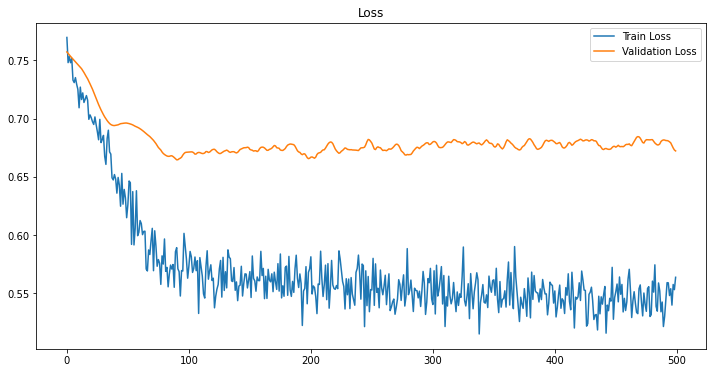

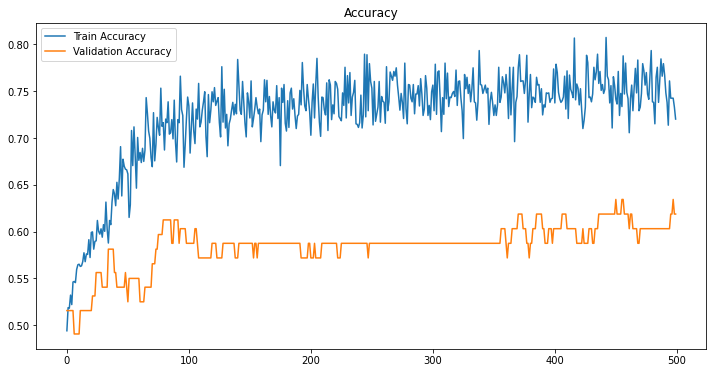

In [8]:
# Plot triain and validation metrics
plt.figure(figsize=(12,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

plt.figure(figsize=(12,6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()
 